# 🧹 Prétraitement et analyse des données 🧹

Dans ce notebook, on analyse les données, on les découpe en train, validation et test et on les prépare pour les méthodes d'apprentissage classiques. Les prétraitements qu'on teste sont :

* la suppression des mots outils
* la lémmatisation

Dépendances et imports nécessaires :

In [ ]:
# le modèle spacy pour la tokénisation
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 49.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import spacy
import fr_core_news_sm
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 600)

## Chargement des données

In [ ]:
# création du dossier data
!mkdir data
# téléchargement des données dans le dossier data
!wget -P data https://git.unistra.fr/dbernhard/ftaa_data/-/raw/main/final_symptom_dataset.csv

mkdir: cannot create directory ‘data’: File exists
--2024-12-09 18:22:45--  https://git.unistra.fr/dbernhard/ftaa_data/-/raw/main/final_symptom_dataset.csv
Resolving git.unistra.fr (git.unistra.fr)... 130.79.254.48
Connecting to git.unistra.fr (git.unistra.fr)|130.79.254.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405296 (396K) [text/plain]
Saving to: ‘data/final_symptom_dataset.csv.1’

final_symptom_datas 100%[===================>] 395.80K  1.03MB/s    in 0.4s    

2024-12-09 18:22:46 (1.03 MB/s) - ‘data/final_symptom_dataset.csv.1’ saved [405296/405296]



In [ ]:
# lecture du fichier csv en dataframe pandas
initial_df = pd.read_csv("data/final_symptom_dataset.csv")

## 🔎 Analyse des données

On dispose d'un jeu de données avec **760** cas classés et groupés par maladie. Le jeu de données se compose de quatre colonnes :

* <u>label_fr</u> : la **maladie** à prédire (colonne catégorielle)
* <u>description</u> : description des symptomes **avec** des termes spécialisés (texte)
* <u>simple</u> : description des symptomes **sans** termes spécialisés (texte)
* <u>fautes</u> : description des symptomes avec des **fautes** (texte)



In [ ]:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label_fr     760 non-null    object
 1   description  760 non-null    object
 2   simple       760 non-null    object
 3   fautes       760 non-null    object
dtypes: object(4)
memory usage: 23.9+ KB


In [ ]:
initial_df.head()

,label_fr,description,simple,fautes
0,acné,Je ressens une éruption cutanée qui me démange beaucoup. J’ai également des points noirs sur le visage et des croûtes qui se forment sur ma peau.,J’ai des boutons qui me grattent beaucoup. J’ai aussi des points noirs sur le visage et des croûtes sur ma peau.,J’ai des bouton ki me gratte beaucoup. J’ai ossi des poin noir sur le visage et des croute sur ma peau.
1,acné,J’ai des boutons remplis de pus qui me font mal. J’ai également des points noirs et des croûtes qui se forment sur ma peau.,J’ai des boutons avec du pus dedans qui me font mal. J’ai aussi des points noirs et des croûtes sur ma peau.,J’ai des bouton avé du pu dedan ki me font mal. J’ai ossi des poin noir et des croute sur ma peau.
2,acné,Je ressens une éruption cutanée avec des boutons remplis de pus. J’ai également des croûtes qui se forment sur ma peau.,J’ai des boutons qui me grattent et qui ont du pus dedans. J’ai aussi des croûtes sur ma peau.,J’ai des bouton ki me gratte et ki on du pu dedan. J’ai ossi des croute sur ma peau.
3,acné,Je ressens une éruption cutanée avec des boutons remplis de pus. J’ai également des points noirs sur le visage.,J’ai des boutons qui me grattent et qui ont du pus dedans. J’ai aussi des points noirs sur le visage.,J’ai des bouton ki me gratte et ki on du pu dedan. J’ai ossi des poin noir sur le visage.
4,acné,Ma peau a récemment été couverte d'une éruption cutanée sévère. Des points noirs et des boutons remplis de pus l'encombrent. Ma peau est également très délicate.,Ma peau a récemment été couverte d'une très mauvaise éruption cutanée. Des points noirs et des boutons remplis de pus l'encombrent. Ma peau est aussi très délicate.,Ma po a récement été couverte d'une tré mauvaise éruption cutané. Des poin noir et des bouton rempli de pus l'encombrent. Ma po est ossi tré délicat.


🔎 Les données sont organisées en **21 catégories différentes** avec les maladies <i>typhoïde</i>, <i>dengue</i> et <i>varices</i> étant les mieux représentées. Il s'agit d'un jeu de données qui contient un nombre relativement restreint de **descriptions courtes**. Il n'est **pas  équilibré**, avec un écart important entre les valeurs extrêmes. Les maladies les plus fréquentes ont un nombre de cas environ 5 fois supérieur à celui de maladies les moins réprésentées. Les maladies les moins fréquentes (<i>acné</i>, <i>paludisme</i> et <i>jaunisse</i>), ont un nombre de cas très restreint et ils risquent d'être mal prédites dans nos expériences.

In [ ]:
# nombre de catégories différentes
categories = initial_df.label_fr.unique()
print(f"Nombre de categories : {len(categories)}")

Nombre de categories : 21


In [ ]:
# distribution de cas
initial_df.label_fr.value_counts()

,count
label_fr,
typhoïde,52
dengue,51
varices,50
varicelle,50
psoriasis,47
asthme bronchique,44
rhume,44
impétigo,44
allergie,39


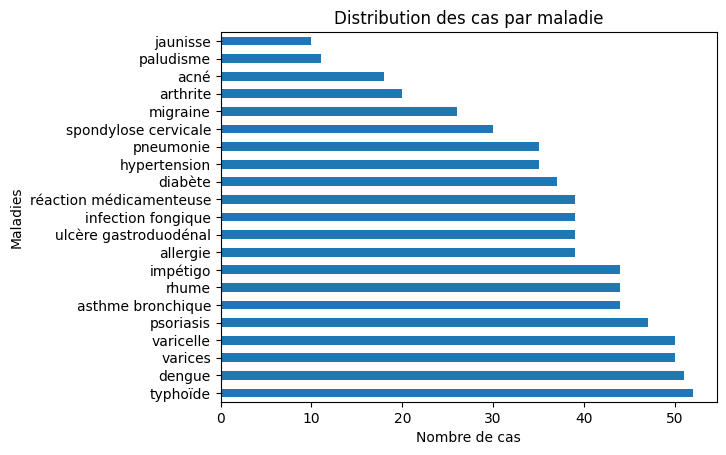

In [ ]:
# visualisation de la distribution
initial_df.label_fr.value_counts().plot(kind="barh")
plt.title("Distribution des cas par maladie")
plt.xlabel("Nombre de cas")
plt.ylabel("Maladies")
plt.show()

## 🧹 Prétraitement des données



In [ ]:
# création de la pipeline pour la tokénisation des données
# désactivation des options pour le parsing syntaxique et la reconnaissance
# des éntités nommées
spacy_tokenisation_pipeline = fr_core_news_sm.load(disable=["parser", "ner"])

In [ ]:
# fonction pour la tokénisation qui rétourne une chaîne de caractères
def split_into_tokens(texte):
  doc = spacy_tokenisation_pipeline(texte)
  return " ".join([word.text for word in doc])

In [ ]:
# fonction pour la tokénisation qui supprime les mots outils et la ponctuation
def split_into_tokens_no_stopwords(texte):
  doc = spacy_tokenisation_pipeline(texte)
  return " ".join([word.text for word in doc if not word.is_stop and not word.is_punct])

In [ ]:
# fonction pour la lémmatisation
def split_into_lemmas(texte):
  doc = spacy_tokenisation_pipeline(texte)
  return " ".join([word.lemma_ for word in doc])

Création des colonnes supplémentaires pour les prétraitements différents :

In [ ]:
initial_df['description_tokens'] = initial_df.description.apply(split_into_tokens)
initial_df['simple_tokens'] = initial_df.simple.apply(split_into_tokens)
initial_df['fautes_tokens'] = initial_df.fautes.apply(split_into_tokens)

In [ ]:
initial_df['description_wosw'] = initial_df.description.apply(split_into_tokens_no_stopwords)
initial_df['simple_wosw'] = initial_df.simple.apply(split_into_tokens_no_stopwords)
initial_df['fautes_wosw'] = initial_df.fautes.apply(split_into_tokens_no_stopwords)

In [ ]:
initial_df['description_lemmas'] = initial_df.description.apply(split_into_lemmas)
initial_df['simple_lemmas'] = initial_df.simple.apply(split_into_lemmas)
initial_df['fautes_lemmas'] = initial_df.fautes.apply(split_into_lemmas)

In [ ]:
# Réorganisation du DataFrame
initial_df = initial_df[["label_fr","description", "description_tokens", "description_wosw", "description_lemmas",
              "simple", "simple_tokens", "simple_wosw", "simple_lemmas",
              "fautes", "fautes_tokens", "fautes_wosw", "fautes_lemmas"]]

🔎 On a choisi de tester l'impact de la suppression des mots outils et de la lémmatisation sur les résultats. Dans les premiers exemples du DataFrame, on voit déjà que cela a bien restreint le nombre de tokens avec le contenu essentiel restant compréhensible.

Il est à noter que la lémmatisation a été moins réussie pour la colonne **fautes**, ce qui n'est pas surprenant mais pourrait influencer les résultats.

In [ ]:
initial_df.head()

,label_fr,description,description_tokens,description_wosw,description_lemmas,simple,simple_tokens,simple_wosw,simple_lemmas,fautes,fautes_tokens,fautes_wosw,fautes_lemmas
0,acné,Je ressens une éruption cutanée qui me démange beaucoup. J’ai également des points noirs sur le visage et des croûtes qui se forment sur ma peau.,Je ressens une éruption cutanée qui me démange beaucoup . J’ ai également des points noirs sur le visage et des croûtes qui se forment sur ma peau .,ressens éruption cutanée démange beaucoup points noirs visage croûtes forment peau,je ressentir un éruption cutané qui me démanger beaucoup . J’ avoir également un point noir sur le visage et de croûte qui se former sur mon peau .,J’ai des boutons qui me grattent beaucoup. J’ai aussi des points noirs sur le visage et des croûtes sur ma peau.,J’ ai des boutons qui me grattent beaucoup . J’ ai aussi des points noirs sur le visage et des croûtes sur ma peau .,boutons grattent beaucoup points noirs visage croûtes peau,J’ avoir un bouton qui me gratter beaucoup . J’ avoir aussi un point noir sur le visage et de croûte sur mon peau .,J’ai des bouton ki me gratte beaucoup. J’ai ossi des poin noir sur le visage et des croute sur ma peau.,J’ ai des bouton ki me gratte beaucoup . J’ ai ossi des poin noir sur le visage et des croute sur ma peau .,bouton ki gratte beaucoup ossi poin noir visage croute peau,J’ avoir un bouton ki me gratter beaucoup . J’ avoir ossi un poin noir sur le visage et de croute sur mon peau .
1,acné,J’ai des boutons remplis de pus qui me font mal. J’ai également des points noirs et des croûtes qui se forment sur ma peau.,J’ ai des boutons remplis de pus qui me font mal . J’ ai également des points noirs et des croûtes qui se forment sur ma peau .,boutons remplis pus mal points noirs croûtes forment peau,J’ avoir un bouton remplir de pus qui me faire mal . j’ avoir également un point noir et de croûte qui se former sur mon peau .,J’ai des boutons avec du pus dedans qui me font mal. J’ai aussi des points noirs et des croûtes sur ma peau.,J’ ai des boutons avec du pus dedans qui me font mal . J’ ai aussi des points noirs et des croûtes sur ma peau .,boutons pus mal points noirs croûtes peau,J’ avoir un bouton avec de pus dedans qui me faire mal . j’ avoir aussi un point noir et de croûte sur mon peau .,J’ai des bouton avé du pu dedan ki me font mal. J’ai ossi des poin noir et des croute sur ma peau.,J’ ai des bouton avé du pu dedan ki me font mal . J’ ai ossi des poin noir et des croute sur ma peau .,bouton avé dedan ki mal ossi poin noir croute peau,J’ avoir un bouton avé de pouvoir dedan ki me faire mal . J’ avoir ossi un poin noir et de croute sur mon peau .
2,acné,Je ressens une éruption cutanée avec des boutons remplis de pus. J’ai également des croûtes qui se forment sur ma peau.,Je ressens une éruption cutanée avec des boutons remplis de pus . J’ ai également des croûtes qui se forment sur ma peau .,ressens éruption cutanée boutons remplis pus croûtes forment peau,je ressentir un éruption cutané avec un bouton remplir de pus . J’ avoir également un croûte qui se former sur mon peau .,J’ai des boutons qui me grattent et qui ont du pus dedans. J’ai aussi des croûtes sur ma peau.,J’ ai des boutons qui me grattent et qui ont du pus dedans . J’ ai aussi des croûtes sur ma peau .,boutons grattent pus croûtes peau,J’ avoir un bouton qui me gratter et qui avoir de pus dedans . J’ avoir aussi un croûte sur mon peau .,J’ai des bouton ki me gratte et ki on du pu dedan. J’ai ossi des croute sur ma peau.,J’ ai des bouton ki me gratte et ki on du pu dedan . J’ ai ossi des croute sur ma peau .,bouton ki gratte ki dedan ossi croute peau,J’ avoir un bouton ki me gratter et ki on de pouvoir dedan . J’ avoir ossi un croute sur mon peau .
3,acné,Je ressens une éruption cutanée avec des boutons remplis de pus. J’ai également des points noirs sur le visage.,Je ressens une éruption cutanée avec des boutons remplis de pus . J’ ai également des points noirs sur le visage

## Découpage des données

In [ ]:
# 20% pour le test, 80% pour l'entraînement
# Random_state = 42, pour la reproductibilité
train_df, test_df = sklearn.model_selection.train_test_split(initial_df, test_size=0.20, train_size=0.80, random_state=42, shuffle=True, stratify=None)

### Données d'entraînement

🔎 Les données d'entraînement comptent 608 cas, soit 80% du jeu de données initial :

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 693 to 102
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   label_fr            608 non-null    object
 1   description         608 non-null    object
 2   description_tokens  608 non-null    object
 3   description_wosw    608 non-null    object
 4   description_lemmas  608 non-null    object
 5   simple              608 non-null    object
 6   simple_tokens       608 non-null    object
 7   simple_wosw         608 non-null    object
 8   simple_lemmas       608 non-null    object
 9   fautes              608 non-null    object
 10  fautes_tokens       608 non-null    object
 11  fautes_wosw         608 non-null    object
 12  fautes_lemmas       608 non-null    object
dtypes: object(13)
memory usage: 66.5+ KB


In [ ]:
# suppression de l'index
train_df.reset_index(drop=True, inplace=True)

In [ ]:
train_df.head()

,label_fr,description,description_tokens,description_wosw,description_lemmas,simple,simple_tokens,simple_wosw,simple_lemmas,fautes,fautes_tokens,fautes_wosw,fautes_lemmas
0,typhoïde,"J'ai beaucoup de ballonnements et de constipation, ce qui est vraiment douloureux. Il y a beaucoup de pression et de douleur dans la région de l'estomac. J'ai une forte fièvre et des frissons chaque nuit.","J' ai beaucoup de ballonnements et de constipation , ce qui est vraiment douloureux . Il y a beaucoup de pression et de douleur dans la région de l' estomac . J' ai une forte fièvre et des frissons chaque nuit .",beaucoup ballonnements constipation vraiment douloureux beaucoup pression douleur région estomac forte fièvre frissons nuit,"je avoir beaucoup de ballonnement et de constipation , ce qui être vraiment douloureux . il y avoir beaucoup de pression et de douleur dans le région de le estomac . je avoir un fort fièvre et de frisson chaque nuit .","J'ai beaucoup de ballonnements et de constipation, ce qui est vraiment douloureux. J'ai beaucoup de pression et de douleur dans le ventre. J'ai une forte fièvre et des frissons chaque nuit.","J' ai beaucoup de ballonnements et de constipation , ce qui est vraiment douloureux . J' ai beaucoup de pression et de douleur dans le ventre . J' ai une forte fièvre et des frissons chaque nuit .",beaucoup ballonnements constipation vraiment douloureux beaucoup pression douleur ventre forte fièvre frissons nuit,"je avoir beaucoup de ballonnement et de constipation , ce qui être vraiment douloureux . je avoir beaucoup de pression et de douleur dans le ventre . je avoir un fort fièvre et de frisson chaque nuit .","J'ai beaucou de baloneman et de constipasion, ce qui est vréman douloureu. J'ai beaucou de presion et de douleur dans le ventre. J'ai une forte fiévre et des frison chaqu nuit.","J' ai beaucou de baloneman et de constipasion , ce qui est vréman douloureu . J' ai beaucou de presion et de douleur dans le ventre . J' ai une forte fiévre et des frison chaqu nuit .",beaucou baloneman constipasion vréman douloureu beaucou presion douleur ventre forte fiévre frison chaqu nuit,"je avoir beaucou de baloneman et de constipasion , ce qui être vréman douloureu . je avoir beaucou de presion et de douleur dans le ventre . je avoir un fort fiévre et de frison chaqu nuit ."
1,réaction médicamenteuse,"Je perds mes cheveux, et la texture de mes cheveux a beaucoup changé. Mon cuir chevelu sec et qui démange, ainsi que mes pellicules, s'aggravent. Ma peau devient également très sèche.","Je perds mes cheveux , et la texture de mes cheveux a beaucoup changé . Mon cuir chevelu sec et qui démange , ainsi que mes pellicules , s' aggravent . Ma peau devient également très sèche .",perds cheveux texture cheveux beaucoup changé cuir chevelu sec démange pellicules aggravent peau devient sèche,"je perdre mon cheveu , et le texture de mon cheveu avoir beaucoup changer . mon cuir chevelu sec et qui démanger , ainsi que mon pellicule , se aggraver . mon peau devenir également très sec .","Je perds mes cheveux, et la texture de mes cheveux a beaucoup changé. Mon cuir chevelu est sec et me démange, et j'ai des pellicules. Ma peau devient aussi très sèche.","Je perds mes cheveux , et la texture de mes cheveux a beaucoup changé . Mon cuir chevelu est sec et me démange , et j' ai des pellicules . Ma peau devient aussi très sèche .",perds cheveux texture cheveux beaucoup changé cuir chevelu sec démange pellicules peau devient sèche,"je perdre mon cheveu , et le texture de mon cheveu avoir beaucoup changer . mon cuir chevelu être sec et me démange , et je avoir un pellicule . mon peau devenir aussi très sec .","Je per mes cheveu, et la texture de mes cheveu a beaucoup changé. Mon cuir chevelu est sec et me démange, et j'ai des pellicule. Ma peau devien aussi tré séche.","Je per mes cheveu , et la texture de mes cheveu a beaucoup changé . Mon cuir chevelu est sec et me démange , et j' ai des pellicule . Ma peau devien aussi tré séche .",per

### Données de test

🔎 Le jeu de test compte 152 cas :

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152 entries, 395 to 333
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   label_fr            152 non-null    object
 1   description         152 non-null    object
 2   description_tokens  152 non-null    object
 3   description_wosw    152 non-null    object
 4   description_lemmas  152 non-null    object
 5   simple              152 non-null    object
 6   simple_tokens       152 non-null    object
 7   simple_wosw         152 non-null    object
 8   simple_lemmas       152 non-null    object
 9   fautes              152 non-null    object
 10  fautes_tokens       152 non-null    object
 11  fautes_wosw         152 non-null    object
 12  fautes_lemmas       152 non-null    object
dtypes: object(13)
memory usage: 16.6+ KB


In [ ]:
# suppression de l'index
test_df.reset_index(drop=True, inplace=True)

In [ ]:
test_df.head()

,label_fr,description,description_tokens,description_wosw,description_lemmas,simple,simple_tokens,simple_wosw,simple_lemmas,fautes,fautes_tokens,fautes_wosw,fautes_lemmas
0,infection fongique,"J'ai beaucoup de démangeaisons sur toute ma peau, et parfois elle devient très rouge et bosselée. Il y a aussi des taches de couleurs différentes du reste de ma peau, et parfois j'ai de petites bosses qui ressemblent à de petites boules. C'est vraiment ennuyeux et ça me démange.","J' ai beaucoup de démangeaisons sur toute ma peau , et parfois elle devient très rouge et bosselée . Il y a aussi des taches de couleurs différentes du reste de ma peau , et parfois j' ai de petites bosses qui ressemblent à de petites boules . C' est vraiment ennuyeux et ça me démange .",beaucoup démangeaisons peau devient rouge bosselée taches couleurs peau petites bosses ressemblent petites boules vraiment ennuyeux démange,"je avoir beaucoup de démangeaison sur tout mon peau , et parfois lui devenir très rouge et bosselée . il y avoir aussi un tache de couleur différent de reste de mon peau , et parfois je avoir de petit bosse qui ressembler à de petit boule . ce être vraiment ennuyeux et cela me démange .","J'ai beaucoup de démangeaisons sur toute ma peau, et parfois elle devient très rouge et bosselée. Il y a aussi des taches de couleurs différentes et de petites bosses qui ressemblent à de petites boules. C'est vraiment ennuyeux et ça me gratte.","J' ai beaucoup de démangeaisons sur toute ma peau , et parfois elle devient très rouge et bosselée . Il y a aussi des taches de couleurs différentes et de petites bosses qui ressemblent à de petites boules . C' est vraiment ennuyeux et ça me gratte .",beaucoup démangeaisons peau devient rouge bosselée taches couleurs petites bosses ressemblent petites boules vraiment ennuyeux gratte,"je avoir beaucoup de démangeaison sur tout mon peau , et parfois lui devenir très rouge et bosselée . il y avoir aussi un tache de couleur différent et de petit bosse qui ressembler à de petit boule . ce être vraiment ennuyeux et cela me gratt .","J'ai beaucoup de démangeaison sur toute ma peau, et parfoi elle devien tré rouge et bosselé. Il y a aussi des tache de couleur diférente et de petite bosse qui ressemble a des petite boule. C'est vraiment ennuyant et sa me gratte.","J' ai beaucoup de démangeaison sur toute ma peau , et parfoi elle devien tré rouge et bosselé . Il y a aussi des tache de couleur diférente et de petite bosse qui ressemble a des petite boule . C' est vraiment ennuyant et sa me gratte .",beaucoup démangeaison peau parfoi devien tré rouge bosselé tache couleur diférente petite bosse ressemble petite boule vraiment ennuyant gratte,"je avoir beaucoup de démangeaison sur tout mon peau , et parfoi lui devien tré rouge et bosselé . il y avoir aussi un tache de couleur diférent et de petit bosse qui ressembler avoir un petit boul . ce être vraiment ennuyant et son me gratt ."
1,diabète,Ma vision est floue et j'ai l'impression que ça empire. Je me sens tout le temps épuisé et fatigué. J'ai aussi parfois des étourdissements et des vertiges extrêmes.,Ma vision est floue et j' ai l' impression que ça empire . Je me sens tout le temps épuisé et fatigué . J' ai aussi parfois des étourdissements et des vertiges extrêmes .,vision floue impression empire sens temps épuisé fatigué étourdissements vertiges extrêmes,mon vision être flou et je avoir le impression que cela empire . je me sentir tout le temps épuiser et fatigué . je avoir aussi parfois un étourdissement et de vertige extrême .,"Je vois flou et ça empire. Je suis toujours fatigué et épuisé. Parfois, j'ai des étourdissements et des vertiges.","Je vois flou et ça empire . Je suis toujours fatigué et épuisé . Parfois , j' ai des étourdissements et des vertiges .",vois flou empire fatigué épuisé étourdissements vertiges,"je voir flou et cela empire . je être toujours fatiguer et épuiser . parfois , je avoir un étourdissement et de vertige .","Je voi flou et sa empire. Je 

#### Distribution de données

🔎 La distribution de données ayant été fait aléatoirement, il y a quelques catégories qui sont plus représentées dans le jeu d'entraînement que dans le jeu de test et vice verca. Cela pourrait influencer les résultats avec les cas les plus représentés dans le jeu d'entraînement étant plus facilement reconnus.

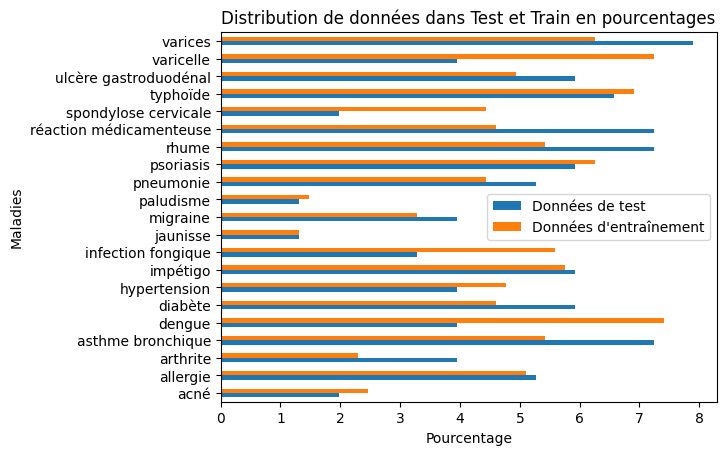

In [ ]:
test_counts = test_df.label_fr.value_counts(normalize=True) * 100
train_counts = train_df.label_fr.value_counts(normalize=True) * 100

# création d'un df
combined_counts = pd.DataFrame({
    'Données de test': test_counts,
    'Données d\'entraînement': train_counts
})

combined_counts.plot(kind="barh", stacked=False)
plt.title("Distribution de données dans Test et Train en pourcentages")
plt.xlabel("Pourcentage")
plt.ylabel("Maladies")
plt.show()

## 💾 Sauvegarde des fichiers en csv

In [ ]:
train_df.to_csv("data/train.csv", sep = ",", index=False)

In [ ]:
test_df.to_csv("data/test.csv", sep = ",", index=False)